In [12]:
from keras.layers import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [13]:
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
import os

# Specify the location of the text file and the folder where images are stored
base_path = "data"
image_folder_path = "lines"

# Create empty variables
Dataset = []
vocab = set()
max_len = 0

with open(f"{base_path}/lines.txt", "r") as file:
    lines = file.readlines()

# Process each line in the text file
for line in lines:
    if line.startswith("#") or "err" in line.split()[1]:
        # Skip lines starting with "#" or containing "err"
        continue

    # Extract information from the line
    parts = line.split()
    line_id = parts[0]
    transcription = parts[-1].strip().replace("|", " ")  # Replace "|" with " "

    # Create folder path and file name
    folder_path = os.path.join(image_folder_path, line_id[:8])
    file_name = f"{parts[0]}.png"
    image_path = os.path.join(folder_path, file_name)

    # Add characters in the transcription to vocab
    vocab.update(transcription)

    # Update max_len if needed
    max_len = max(max_len, len(transcription))

    # Add image path and label to Dataset
    Dataset.append((image_path, transcription))

# Print the Dataset, vocab, and max_len
print("Dataset:")
for entry in Dataset:
    print(entry)

print("\nVocabulary:", vocab)
print("\nMaximum Label Length:", max_len)


Dataset:
('lines\\a01-000u\\a01-000u-00.png', 'A MOVE to stop Mr. Gaitskell from')
('lines\\a01-000u\\a01-000u-01.png', 'nominating any more Labour life Peers')
('lines\\a01-000u\\a01-000u-02.png', 'is to be made at a meeting of Labour')
('lines\\a01-000u\\a01-000u-04.png', 'put down a resolution on the subject')
('lines\\a01-000u\\a01-000u-06.png', 'P for Manchester Exchange .')
('lines\\a01-000x\\a01-000x-00.png', 'A MOVE to stop Mr. Gaitskell from nominating')
('lines\\a01-000x\\a01-000x-01.png', 'any more Labour life Peers is to be made at a')
('lines\\a01-000x\\a01-000x-02.png', 'Ps tomorrow . Mr. Michael')
('lines\\a01-000x\\a01-000x-03.png', 'Foot has put down a resolution on the subject')
('lines\\a01-000x\\a01-000x-04.png', 'and he is to be backed by Mr. Will Griffiths ,')
('lines\\a01-000x\\a01-000x-05.png', 'P for Manchester Exchange .')
('lines\\a01-003-\\a01-003-00.png', 'Though they may gather some Left-wing support , a')
('lines\\a01-003-\\a01-003-01.png', 'Ps are likely

In [53]:
"""
## Dataset splitting
"""
base_path = "data"
data_path = "data" #"D:\data"
words_list = []

words = open(f"{base_path}/lines.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)
        
print("Wordlength:",len(words_list))
np.random.shuffle(words_list)

Wordlength: 11344


In [54]:
"""
We will split the dataset into three subsets with a 90:5:5 ratio (train:validation:test).
"""

split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(test_samples)

print(f"Total training samples: {len(train_samples)}", train_samples[0:2])
print(f"Total validation samples: {len(validation_samples)}", validation_samples[0:2])
print(f"Total test samples: {len(test_samples)}", test_samples[0:2])

Total training samples: 10209 ['h01-014-01 ok 152 41 352 923 1827 137 about|housing|and|households|.|In|1961|the|scope|of|the\n', 'g06-018e-04 ok 162 22 357 1447 1713 105 Naples|.|The|journey|has|been|against|me|,|as|there|has\n']
Total validation samples: 567 ['f02-076-00 ok 182 26 291 740 1872 132 1|.|Are|there|differences|in|adjustment|to|ageing\n', 'b03-092-00 ok 152 43 376 742 1595 82 Comprehensive|legislation|is|obviously|preferable|.|They|should|not|,\n']
Total test samples: 568 ['p02-101-01 ok 176 43 330 887 1819 158 taste|but|it|was|unkind|beyond|words|.|She|fumbled\n', 'd06-003-00 ok 155 35 319 727 1771 131 Even|worse|is|to|laugh|.|Tremendous|damage|may|be|done|to|a|child\n']


In [56]:
"""
## Data input pipeline

We start building our data input pipeline by first preparing the image paths.
"""

base_image_path = os.path.join(data_path, "lines")


def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for _, file_line in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(base_image_path, partI, partI + "-" + partII, image_name + ".png")
        
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [57]:
print(f"Training: {train_img_paths[0:2]}", train_labels[0:2])
print(f"Validation: {validation_img_paths[0:2]}", validation_labels[0:2])
print(f"Testing: {test_img_paths[0:2]}", test_labels[0:2])
train_img_paths[0:10]
train_labels[0:10]

Training: ['data\\lines\\h01\\h01-014\\h01-014-01.png', 'data\\lines\\g06\\g06-018e\\g06-018e-04.png'] ['h01-014-01 ok 152 41 352 923 1827 137 about|housing|and|households|.|In|1961|the|scope|of|the', 'g06-018e-04 ok 162 22 357 1447 1713 105 Naples|.|The|journey|has|been|against|me|,|as|there|has']
Validation: ['data\\lines\\f02\\f02-076\\f02-076-00.png', 'data\\lines\\b03\\b03-092\\b03-092-00.png'] ['f02-076-00 ok 182 26 291 740 1872 132 1|.|Are|there|differences|in|adjustment|to|ageing', 'b03-092-00 ok 152 43 376 742 1595 82 Comprehensive|legislation|is|obviously|preferable|.|They|should|not|,']
Testing: ['data\\lines\\p02\\p02-101\\p02-101-01.png', 'data\\lines\\d06\\d06-003\\d06-003-00.png'] ['p02-101-01 ok 176 43 330 887 1819 158 taste|but|it|was|unkind|beyond|words|.|She|fumbled', 'd06-003-00 ok 155 35 319 727 1771 131 Even|worse|is|to|laugh|.|Tremendous|damage|may|be|done|to|a|child']


['h01-014-01 ok 152 41 352 923 1827 137 about|housing|and|households|.|In|1961|the|scope|of|the',
 'g06-018e-04 ok 162 22 357 1447 1713 105 Naples|.|The|journey|has|been|against|me|,|as|there|has',
 'e04-127-05 ok 173 38 358 1620 1770 146 into|a|variety|of|shapes|they|can|be|combined|by|either',
 'a06-141-05 ok 178 25 343 1822 1867 71 eyes|there|has|sprung|up|a|regular|army|led|by|former|Nazi',
 'g01-083-01 ok 144 27 332 1105 1841 90 to|mediaeval|eyes|.|It|was|determined|that|100,000',
 'a04-085-05 ok 172 38 351 1788 1746 151 Macmillan|yesterday|morning|he|was|given',
 'j06-000-07 ok 189 33 369 1934 1807 157 from|the|Antarctic|,|the|metanauplii|remain',
 "g06-018j-03 ok 182 36 332 1207 1879 178 as|usual|'|,|but|hoped|,|he|told|Arthur|,|'|to|find",
 "c04-044-05 ok 187 16 281 1450 1872 231 Holloway's|act|too|long|and|not|particularly",
 'p03-057-05 ok 203 28 366 1575 1557 114 I|know|?|"|she|smiled|.|"|I|think|so|.']

In [58]:
"""
Then we prepare the ground-truth labels.
"""

# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  93
Vocab size:  79


['about|housing|and|households|.|In|1961|the|scope|of|the',
 'Naples|.|The|journey|has|been|against|me|,|as|there|has',
 'into|a|variety|of|shapes|they|can|be|combined|by|either',
 'eyes|there|has|sprung|up|a|regular|army|led|by|former|Nazi',
 'to|mediaeval|eyes|.|It|was|determined|that|100,000',
 'Macmillan|yesterday|morning|he|was|given',
 'from|the|Antarctic|,|the|metanauplii|remain',
 "as|usual|'|,|but|hoped|,|he|told|Arthur|,|'|to|find",
 "Holloway's|act|too|long|and|not|particularly",
 'I|know|?|"|she|smiled|.|"|I|think|so|.']

In [59]:
"""
Now we clean the validation and the test labels as well.
"""

def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [60]:
print(f"Train Cleaned: {train_labels_cleaned[0:10]}")
print(f"Validation Cleaned: {validation_labels_cleaned[0:10]}")
print(f"Test Cleaned: {test_labels_cleaned[0:10]}")

Train Cleaned: ['about|housing|and|households|.|In|1961|the|scope|of|the', 'Naples|.|The|journey|has|been|against|me|,|as|there|has', 'into|a|variety|of|shapes|they|can|be|combined|by|either', 'eyes|there|has|sprung|up|a|regular|army|led|by|former|Nazi', 'to|mediaeval|eyes|.|It|was|determined|that|100,000', 'Macmillan|yesterday|morning|he|was|given', 'from|the|Antarctic|,|the|metanauplii|remain', "as|usual|'|,|but|hoped|,|he|told|Arthur|,|'|to|find", "Holloway's|act|too|long|and|not|particularly", 'I|know|?|"|she|smiled|.|"|I|think|so|.']
Validation Cleaned: ['1|.|Are|there|differences|in|adjustment|to|ageing', 'Comprehensive|legislation|is|obviously|preferable|.|They|should|not|,', 'was|swamped|by|the|know-how|of|Marilyn|Monroe', 'enigma|,|seen|but|not|heard|.|However|,|Miss|Pinkie', 'instrument|,|and|her|head|was|smashed|in|.', 'head-stones|in|the|churchyard|,|"|sacred|to', 'building|bombers|,|and|added|:', 'nature|-|I|assumed|that|you|both|knew|who|I', 'path|fringed|and|shaded|by|ci

In [61]:
"""
### Building the character vocabulary

Keras provides different preprocessing layers to deal with different modalities of data.
[This guide](https://keras.io/guides/preprocessing_layers/) provides a comprehensive introduction.
Our example involves preprocessing labels at the character
level. This means that if there are two labels, e.g. "cat" and "dog", then our character
vocabulary should be {a, c, d, g, o, t} (without any special tokens). We use the
[`StringLookup`](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup/)
layer for this purpose.
"""

AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [142]:
# Beispiel: Annahme, dass sentences eine Liste von Sätzen ist.
sentence = ["This|is|sentence|", "This|is|sentence|2"]

# Mapping sentences to integers.
sentence_to_num = tf.keras.layers.StringLookup(
    vocabulary=sentence, mask_token=None, num_oov_indices=0, oov_token="|"
)

# Mapping integers back to original sentences.
num_to_sentence = tf.keras.layers.StringLookup(
    vocabulary=sentence_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [145]:
print(num_to_sentence(tf.constant([1,2])))
print(num_to_char(tf.constant([1,2,3,4,5,6,7,8,8,10])))

tf.Tensor([b'This|is|sentence|' b'This|is|sentence|2'], shape=(2,), dtype=string)
tf.Tensor([b'!' b'"' b'#' b'&' b"'" b'(' b')' b'*' b'*' b','], shape=(10,), dtype=string)


In [62]:
"""
### Resizing images without distortion

Instead of square images, many OCR models work with rectangular images. This will become
clearer in a moment when we will visualize a few samples from the dataset. While
aspect-unaware resizing square images does not introduce a significant amount of
distortion this is not the case for rectangular images. But resizing images to a uniform
size is a requirement for mini-batching. So we need to perform our resizing such that
the following criteria are met:

* Aspect ratio is preserved.
* Content of the images is not affected.
"""


def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(image, paddings=[[pad_height_top, pad_height_bottom],[pad_width_left, pad_width_right],[0, 0],],)

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [ ]:
"""
If we just go with the plain resizing then the images would look like so:

![](https://i.imgur.com/eqq3s4N.png)

Notice how this resizing would have introduced unnecessary stretching.
"""

In [146]:
"""
### Putting the utilities together
"""
batch_size = 128
padding_token = 0
image_width = 1408
image_height = 96

In [147]:
def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

In [148]:
def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label

In [149]:
def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}

In [150]:
def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(process_images_labels, num_parallel_calls=AUTOTUNE)
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [151]:
"""
## Prepare `tf.data.Dataset` objects
"""

train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)


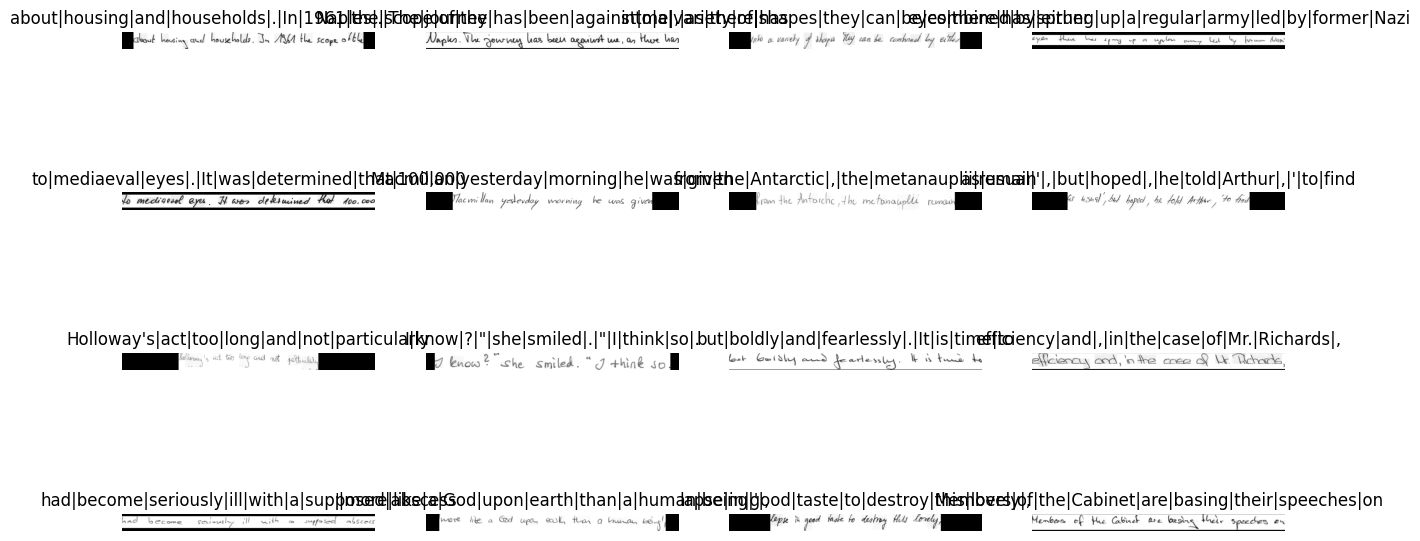

In [152]:
"""
## Visualize a few samples
"""
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    ax = plt.subplots(4, 4, figsize=(15, 8))[1]

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")

In [153]:
"""
## Model

Our model will use the CTC loss as an endpoint layer. For a detailed understanding of the
CTC loss, refer to [this post](https://distill.pub/2017/ctc/).
"""
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred

In [154]:
def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1")(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2")(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="handwriting_recognizer")

    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model

In [155]:
# Get the model.
model = build_model()
model.summary()


Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 1408, 96, 1)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 1408, 96, 32)         320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 704, 48, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 Conv2 (Conv2D)              (None, 704, 48, 64)          18496     ['pool1[0][0]']               
                                                                            

In [156]:
"""
## Evaluation metric

[Edit Distance](https://en.wikipedia.org/wiki/Edit_distance)
is the most widely used metric for evaluating OCR models. In this section, we will
implement it and use it as a callback to monitor our model.
"""

"""
We first segregate the validation images and their labels for convenience.
"""
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])


In [157]:
"""
Now, we create a callback to monitor the edit distances.
"""


def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(predictions, input_length=input_len, greedy=True)[0][0][:, :max_len]
    sparse_predictions = tf.cast(tf.sparse.from_dense(predictions_decoded), dtype=tf.int64)

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(sparse_predictions, saprse_labels, normalize=False
                                      )
    return tf.reduce_mean(edit_distances)

In [158]:
class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}")

In [159]:
"""
## Training

Now we are ready to kick off model training.
"""
epochs = 1  # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(model.get_layer(name="image").input, model.get_layer(name="dense2").output)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(train_ds, validation_data=validation_ds, epochs=epochs, callbacks=[edit_distance_callback])

2/2 [==============================] - 2s 216ms/step
Mean edit distance for epoch 1: 93.0000
80/80 [==============================] - 718s 8s/step - loss: 261.8697 - val_loss: 202.7213


In [160]:
"""
## Inference
"""
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:,:max_len]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

4/4 [==============================] - 1s 303ms/step


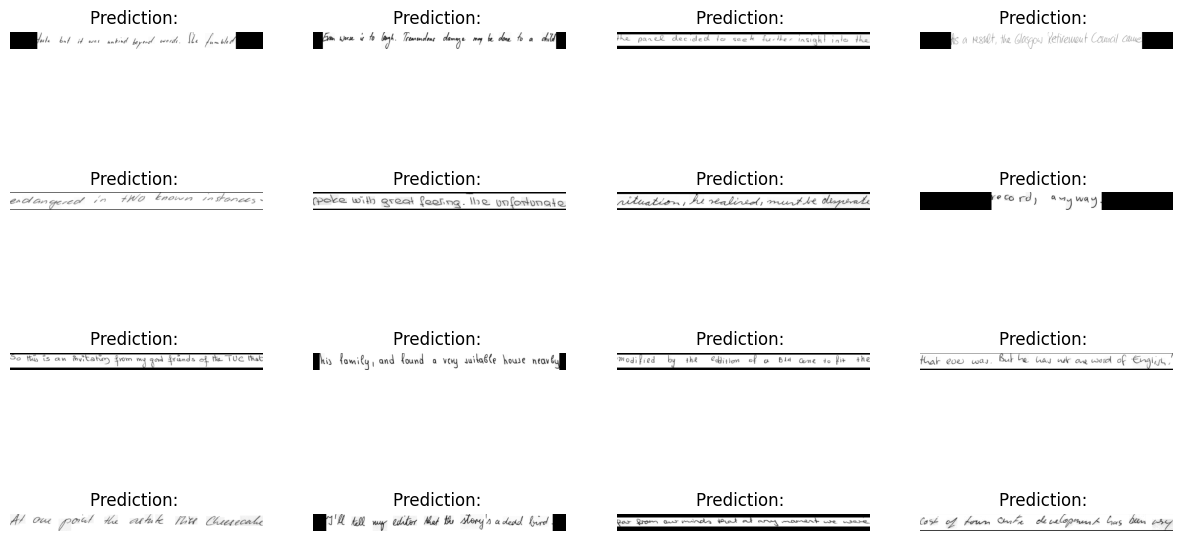

In [161]:
#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    ax = plt.subplots(4, 4, figsize=(15, 8))[1]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [ ]:
"""
To get better results the model should be trained for at least 50 epochs.
"""

"""
## Final remarks

* The `prediction_model` is fully compatible with TensorFlow Lite. If you are interested,
you can use it inside a mobile application. You may find
[this notebook](https://github.com/tulasiram58827/ocr_tflite/blob/main/colabs/captcha_ocr_tflite.ipynb)
to be useful in this regard.
* Not all the training examples are perfectly aligned as observed in this example. This
can hurt model performance for complex sequences. To this end, we can leverage
Spatial Transformer Networks ([Jaderberg et al.](https://arxiv.org/abs/1506.02025))
that can help the model learn affine transformations that maximize its performance.
"""